# Quantify transports through the Faroe-Shetland Channel by source and destination

- Lagrangian particle tracking in VIKING20X model

- Pilot test case for June 2016

- Particles tracked backwards for 2 years (for sources) and forward for 6 months (for destinations)

- Advection only

- Transport calculations based on the idea of particle track representing a streamtube with constant along-tube transport everywhere

This is one in a series of notebooks exploring the tracking output. Here we
- load lagrangian trajectory data that has been written by OceanParcels from particle tracking in Viking20x model (currently using monthly mean fields for speed)
    - particles tracked from a section across IFR
    - random release points along section
    - tracked forward for 6 months to id destinations
    - tracked backwards for 2 years to id sources
- use this to plot timeseries of transport through the source sections

Transports associated with different pathways are estimated by assuming that each particle crossing FS Channel has an associated volume transport, which it maintains throughout its life, given by the 
                velocity across the section * total cross-sectional area / number of particles
So like a streamtube...    

I suspect that most of the volume transport is coming through quite quickly following the eastern boundary, but may be obscured in track plots and animations by all the eddying motions. Trying to check this with total transport and transport with longitude time series across the section.

## Technical preamble

In [2]:
%matplotlib inline

import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib.colors import ListedColormap
import cmocean as co

sns.set_palette("colorblind")

## Parameters

In [3]:
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# project_path = Path("C:/Users/sa05af/OneDrive - SAMS/Projects/parcels_quantitative_202004/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/FaroeShetland/') 
filename = 'test_forwards.nc'
filenameb = 'test_backwards.nc'

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#velocity conversions on IFR (61N)

lat2metres = 60.0*1852.0
lon2metres = 60.0*1852.0*np.cos(np.radians(61.0))

sealandratio = 5591.0/20000.0
sectionAreaEW = 5.7 * 1500.0 * sealandratio * lon2metres  # very approx. mean depth x length between slopes.
sectionAreaNS = 1.87 * 1500.0 * sealandratio * lat2metres

nParticles = 2000.0

## Some helper and plotting functions

In [4]:
def plot_release():
    plt.figure(figsize = (12,5))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        20,
        ds.isel(obs=0).vvel.data.flatten()*lon2metres
         , vmin = -.2, vmax = .2
        ,cmap= co.cm.balance
    #    ,alpha=0.3
    )

    plt.ylim(1500,0)

    plt.colorbar(label = "vvel [m/s]")
    plt.show()
    return


In [5]:
def plot_tracks(x,y,z,title):
    plt.figure(figsize = (12,9))

    # plot tracks as scatter plots

    plt.scatter(
        x
        ,y
        ,3
        ,z
        ,vmin = tvmin, vmax = tvmax
        ,cmap = co.cm.delta
    #    ,alpha=0.3
    )
    plt.colorbar(label = "time [stupid units. range 4 years, all cross IFR at 2 years]");

    # plot depth contours and land boundary from model bathymetry
    depth.isel(y=slice(1700, 2499), x=slice(1300, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'grey', levels = [200,800,1500,2000,2500,3500]
    );
    depth.isel(y=slice(1700, 2499), x=slice(1300, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'k', levels = [1]
    );
    # plt.savefig('upstream.png')
    plt.ylim(45,70)
    plt.xlim(-30,10)
    plt.title(title)
    plt.show()
    return

In [6]:
def plot_section_from_NW():
    plt.figure(figsize = (12,6))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        s = 20, color = 'k', label='from other, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).z.data.flatten(),
        s = 20, color = 'blue', label='from IFR, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).where(ds_area.isel(obs=-1).T_NorwSea).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).isel(obs=0).where(ds_area.isel(obs=-1).T_NorwSea).z.data.flatten(),
        s = 20, color = 'lightblue', label='from IFR, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).isel(obs=0).z.data.flatten(),
        s = 20, color = 'red', label='from W Iceland, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_WIceland).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'pink', label='from W Iceland, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'green', label='from Greenland Sea, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes).where(ds_area.isel(obs=-1).F_GreenSea).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'lightgreen', label='from Greenland Sea, went Norwegian Sea'
    )

    plt.legend(ncol=2)

    plt.ylim(1800,0)
    
    return

In [7]:
def plot_section_not_from_NW():
    plt.figure(figsize = (12,6))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        s = 20, color = 'k', label='from other, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).isel(obs=0).z.data.flatten(),
        s = 20, color = 'green', label='from WRB, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'lightgreen', label='from WRB, went North Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_WRB).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'cyan', label='from WRB, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).isel(obs=0).z.data.flatten(),
        s = 20, color = 'red', label='from RT, went other'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'pink', label='from RT, went North Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, color = 'coral', label='from RT, went Norwegian Sea'
    )
    plt.legend(ncol=2)

    plt.ylim(1800,0)
    
    return

In [8]:
def apply_through_area(ds, min_lon, max_lon, min_lat, max_lat, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  (
                    (ds.lon > min_lon) * 
                    (ds.lon < max_lon) *
                    (ds.lat > min_lat) * 
                    (ds.lat < max_lat) *
                    (ds.time > min_time) *
                    (ds.time < max_time)
                    )
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [9]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  ((((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                     > 0.0) *
                    (ds.time > min_time) *
                    (ds.time < max_time))
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [10]:
def mask_tracks_by_source_sink(ds_full):
    # comes through Rockall Trough and W Scotland shelf
    ds_area = apply_through_area(ds_full,-13.5,-6.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),np.datetime64('2016-06-15'),
                                 'F_RT_WSS')    
    # comes northward west of Rockall Bank
    ds_area = apply_through_area(ds_area,-60,-13.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),np.datetime64('2016-06-15'),
                                 'F_WRB')  
    # comes clockwise round Iceland
    ds_area = apply_through_area(ds_area,-22,-20,65,70,np.datetime64('2010-06-15'),
                                 np.datetime64('2016-06-15'),
                                 'F_WIceland')  
    # comes from NW
    ds_area = apply_through_area(ds_area,-20,-6,68.5,70,
                                 np.datetime64('2010-06-15'),np.datetime64('2016-06-15'),
                                 'F_GreenSea')  
    # goes northeastward towards Arctic - all particles doing this pass north of Faroe
    ds_area = apply_through_area(ds_area,-6.5,-5.5,62.3,64.5,
                                 np.datetime64('2010-06-15'),np.datetime64('2016-06-15'),
                                 'F_NFaroes')    
    # goes west south of Iceland in SPG
    ds_area = apply_through_area(ds_area,-23,-22,62.,64.,
                                 np.datetime64('2016-06-15'),np.datetime64('2020-06-15'),
                                 'T_SIceland')  
    # goes to arctic
    ds_area = apply_left_of_line(ds_area,0,7,65,62,
                                 np.datetime64('2016-06-15'),np.datetime64('2020-06-15'),
                                 'T_NorwSea')
    # goes to north sea
    ds_area = apply_left_of_line(ds_area,5.1,-1.23,62.3,60.3,
                                 np.datetime64('2016-06-15'),np.datetime64('2020-06-15'),
                                 'T_NSea')
    return ds_area

In [11]:
def transports():
    NEwardsParticleTransport = (sectionAreaEW*dsb.isel(obs=0).vvel*lat2metres +
                            sectionAreaNS*dsb.isel(obs=0).uvel*lon2metres)/nParticles
    print('Total transport through F-S channel.....................',
          '{: .3f}'.format(NEwardsParticleTransport.sum().data/1.0e06),'  Sv')
    print('...from NW..............................................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes).sum().data/1.0e06),'  Sv')
    print('...excluding from NW....................................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).sum().data/1.0e06),'  Sv')
    print('.............of which............ from Rockall Trough...',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS).sum().data/1.0e06),'  Sv')
    print('.............of which............ from West of Rockall..',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_NFaroes == False).where(ds_area.isel(obs=-1).F_RT_WSS == False).where(ds_area.isel(obs=-1).F_WRB).sum().data/1.0e06),'  Sv')
    return

## Load data

### Forward tracks then backward tracks

In [12]:
ds = xr.open_dataset(project_path / path_data_tracks / filename)
dsb = xr.open_dataset(project_path / path_data_tracks / filenameb)
ds_full = xr.concat([dsb,ds],dim='obs')

display(ds_full)

<xarray.Dataset>
Dimensions:     (obs: 917, traj: 2000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 3.0 3.0 3.0 ... 7.14e+03 7.14e+03 7.14e+03
    time        (traj, obs) datetime64[ns] 2016-06-15T12:00:00 ... 2016-12-17T12:00:00
    lat         (traj, obs) float64 61.17 61.18 61.19 61.2 ... 64.25 64.34 64.42
    lon         (traj, obs) float64 -3.858 -3.798 -3.735 ... 5.359 5.28 5.181
    z           (traj, obs) float64 551.4 554.3 557.1 ... 369.0 363.4 354.3
    temp        (traj, obs) float32 1.3506522 1.3615055 ... 5.8584743 5.7568445
    uvel        (traj, obs) float32 -9.869915e-07 ... -1.2129784e-06
    vvel        (traj, obs) float32 -2.6944662e-08 ... 8.970269e-07
    wvel        (traj, obs) float32 -4.380481e-05 ... -0.00011414275
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.2
    parcels_mesh:           spherical

### Load model mesh mask

In [13]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

## Calculate some basic parameters from data for later

In [14]:
nParticles = ds.sizes['traj']

In [15]:
#centre time colourscale on release *DOESN'T WORK ON WINDOWS*
tvmin = dsb.time.min(skipna=True).data # oldest time
tvcentre = dsb.time.max(skipna=True).data # oldest time

tvmax = tvcentre + (tvcentre - tvmin)

### Find subsets of trajectories passing through different areas, either upstream or downstream

This just tests whether particles were ever in an area, much easier than testing line crossings.

In [16]:
ds_area = mask_tracks_by_source_sink(ds_full)

## Plot tracks and time series for some cases

### Tracks reaching FSC from south through Rockall Trough

In [17]:
lon =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS).lon.data.flatten()
lat =    ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS).lat.data.flatten()
time =   ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS).time.data.flatten()

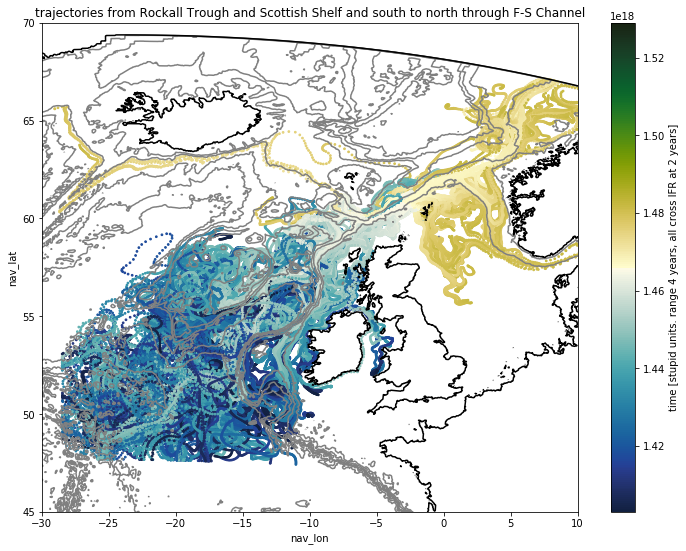

In [18]:
plot_tracks(lon,lat,time,'trajectories from Rockall Trough and Scottish Shelf and south to north through F-S Channel')

### Tracks reaching FSC from south from west of Rockall

In [33]:
lon =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).lon.data.flatten())
lat =    (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).lat.data.flatten())
time =   (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                .where(ds_area.isel(obs=-1).F_RT_WSS == False)
                .where(ds_area.isel(obs=-1).F_WRB).time.data.flatten())

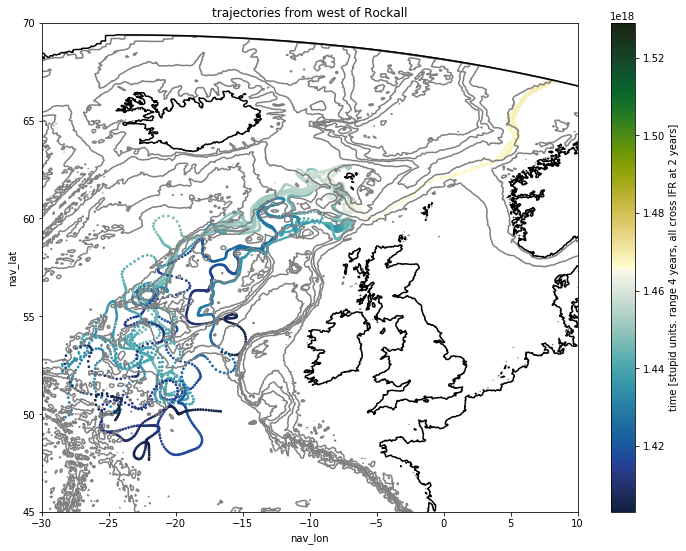

In [34]:
plot_tracks(lon,lat,time,'trajectories from west of Rockall')

### Transport time series

In [126]:
NEwardsParticleTransport = (sectionAreaEW*dsb.isel(obs=0).vvel*lat2metres +
                            sectionAreaNS*dsb.isel(obs=0).uvel*lon2metres)/(nParticles*1.0e06)

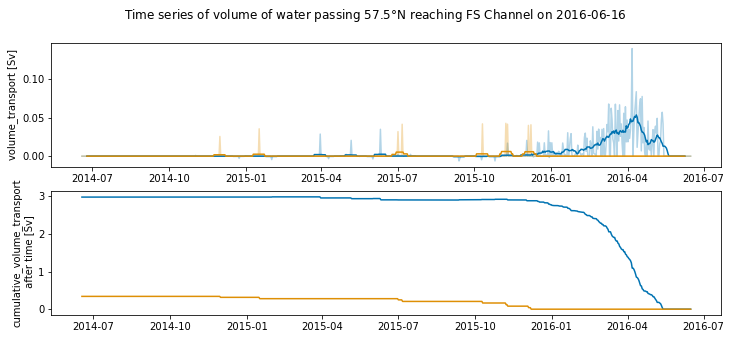

In [125]:
y = NEwardsParticleTransport*ds_area.F_RT_WSS*(1-ds_area.F_NFaroes)
y1 = NEwardsParticleTransport*ds_area.F_WRB*(1-ds_area.F_RT_WSS)*(1-ds_area.F_NFaroes)

y.name = y1.name = 'volume_transport'
y.attrs["units"] = y1.attrs["units"] = 'Sv'

fig,ax = plt.subplots(2,figsize = (12,5))

fig.suptitle('Time series of volume of water passing $57.5\degree$N reaching FS Channel on 2016-06-16')
ax[0].set_ylabel(y.name + ' ['+y.attrs["units"]+']')
ax[0].plot(ds_area.time.min("traj",skipna = True).data[:729],y.sum("traj")[:730].diff("obs"),alpha = 0.3)
ax[0].plot(ds_area.time.min("traj",skipna = True).data[:729],y1.sum("traj")[:730].diff("obs"),alpha = 0.3)
ax[0].set_prop_cycle(None)
ax[0].plot(ds_area.time.min("traj",skipna = True).data[:729],
        y.sum("traj")[:730].diff("obs").rolling(obs=14,center = True).mean())
ax[0].plot(ds_area.time.min("traj",skipna = True).data[:729],
        y1.sum("traj")[:730].diff("obs").rolling(obs=14,center = True).mean())


ax[1].set_ylabel('cumulative_'+y.name + '\n after time ['+y.attrs["units"]+']')
ax[1].plot(ds_area.time.min("traj",skipna = True).data[:730],y.sum("traj")[:730])
ax[1].plot(ds_area.time.min("traj",skipna = True).data[:730],y1.sum("traj")[:730])

plt.show()

## Estimate transports through FSC

In [41]:
transports()

Total transport through F-S channel.....................  1.464   Sv
...from NW.............................................. -1.909   Sv
...excluding from NW....................................  3.373   Sv
.............of which............ from Rockall Trough...  2.977   Sv
.............of which............ from West of Rockall..  0.340   Sv
